# Classification of Text Documents with Topic Model 

In [93]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models, similarities
import re
import random
import time
import pickle

import sklearn
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import labeled oag data with labled tweets (all tweets labled as 0--nonfraud)
oag_data = pd.read_pickle('../data/tweets_and_OAG_corpus-1.pkl')
len(oag_data)

35675

In [3]:
oag_data = oag_data[oag_data.loc[:,'cusp_code']!=1]
oag_data['cusp_code'] = oag_data['cusp_code'].replace(0,1)
oag_data['cusp_code'] = oag_data['cusp_code'].replace(9999,0)

In [4]:
oag_data.head()

,original_Index,documents,fraud,cusp_code,cleanedDocs,doc_len
0,0,I attempted to purchase two tickets to see ---...,1,2,"[attempted, purchase, tickets, -----, Oyster, ...",77
1,1,Note User indicated supporting documents will ...,1,4,"[Note, User, indicated, supporting, documents,...",182
2,2,Note User indicated supporting documents will ...,1,8,"[Note, User, indicated, supporting, documents,...",30
3,3,I contracted with this company ----- for a mov...,1,2,"[contracted, company, -----, move, -----, ----...",239
4,4,I had to contact them including - personal tim...,1,5,"[contact, including, personal, time, consuming...",25


In [206]:
# lenlist = [len(i) for i in list(oag_data.cleanedDocs)]
# print min(lenlist)
# print np.mean(lenlist)

In [6]:
len(oag_data)

34217

In [7]:
print oag_data.fraud.unique()
print oag_data.cusp_code.unique()

[1 0]
[2 4 8 5 7 1 3 6 0]


In [8]:
Categoary_Index = ['Irrelevant', 'Residential', 'scams', 'misc', 'financial', 'good_n_services', 'government', 'utilities', 'travel']

In [9]:
# Index lable
Index_table = oag_data[['cusp_code','fraud']].groupby(['cusp_code']).count().rename(columns={'fraud': 'Count'})
Index_table['Categoary'] = Categoary_Index
Index_table

,Count,Categoary
cusp_code,,
0,25337,Irrelevant
1,792,Residential
2,1123,scams
3,1837,misc
4,1363,financial
5,1253,good_n_services
6,259,government
7,828,utilities
8,1425,travel


In [10]:
# tokenize
doc_tokenize = list(oag_data['cleanedDocs'])
doc_tokenize = [[word for word in document if '--' not in word] for document in doc_tokenize]

In [11]:
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in doc_tokenize:
    for token in text:
        frequency[token] += 1
doc_tokenize = [[token for token in text if frequency[token] > 1] for text in doc_tokenize]

In [12]:
# Phrases Detection
bigram = gensim.models.Phrases(doc_tokenize, threshold=50.0)
phrases_texts = bigram[doc_tokenize]

In [13]:
# transform into dictionary
dictionary = corpora.Dictionary(phrases_texts)

In [14]:
print (dictionary)

Dictionary(46565 unique tokens: [u'sambung', u'deferment', u'EXPLAIN', u'Poetry', u'woods']...)


In [15]:
# bag of word
corpus = [dictionary.doc2bow(text) for text in phrases_texts]

In [16]:
# tfidf transform
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [17]:
# train LDA model with 500 topics
start_time = time.time()
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=500, passes=5)
X = lda.do_estep(corpus_tfidf, state=None)
end_time = time.time()
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

Training it took 11.0 mins


## Train on two classes

In [19]:
# Creat target list
target = list(oag_data.fraud)

In [20]:
# Train test split
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=1)

In [21]:
# SVM linear
start_time = time.time()
svc = SVC(kernel='linear')
svc.fit(X_train, target_train)
pred = svc.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with linear =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with linear =', 0.9844145723748295)
Training it took 0.6 mins


In [22]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      7552
          1       0.99      0.95      0.97      2714

avg / total       0.98      0.98      0.98     10266



In [23]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm


Confussion matrix :
[[7518   34]
 [ 126 2588]]


In [24]:
def plot_confusion_matrix(cm, label, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

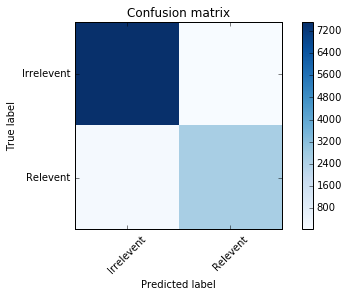

In [25]:
plt.figure()
plot_confusion_matrix(cm, title='Confusion matrix', label=['Irrelevent','Relevent'])
plt.show()

## Train on multiple classes / Model Selection

In [26]:
# creat target
target = list(oag_data.cusp_code)

In [27]:
# Train test split
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=1)

##### SVM linear

In [65]:
# SVM linear
start_time = time.time()
svc_multiple = SVC(kernel='linear')
svc_multiple.fit(X_train, target_train)
pred = svc_multiple.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with linear =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with linear =', 0.849892850185077)
Training it took 1.8 mins


In [66]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      7552
          1       0.62      0.54      0.58       244
          2       0.37      0.38      0.37       336
          3       0.34      0.43      0.38       548
          4       0.49      0.47      0.48       397
          5       0.45      0.33      0.38       412
          6       0.53      0.22      0.31        78
          7       0.66      0.40      0.50       262
          8       0.67      0.59      0.63       437

avg / total       0.84      0.85      0.85     10266



In [67]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm
print 'relevent recall', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent precision', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))


Confussion matrix :
[[7531    1    1    7    6    3    0    0    3]
 [  16  131   14   44   12   10    1    3   13]
 [  32    9  126   73   30   41    1    7   17]
 [  49   28   60  237   79   42    4   15   34]
 [  34    9   21  109  185   17    4    5   13]
 [  48    9   56   94   21  135    2   19   28]
 [  14    6    6   21    7    3   17    0    4]
 [  16    9   19   52   21   24    2  106   13]
 [  29    9   34   61   14   27    1    5  257]]
relevent recall 0.991589907889
relevent precision 0.912306558585


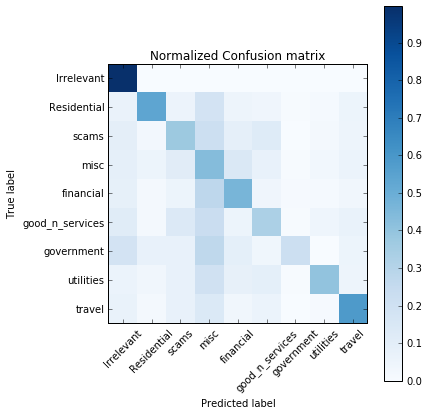

In [68]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Categoary_Index)
plt.show()

##### Multinomial Naive Bayes Model

In [69]:
# Multinomial NAive Bayes Model
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
start_time = time.time()
nvb1 = MultinomialNB(alpha=0.1)
nvb1.fit(X_train, target_train)
pred = nvb1.predict(X_test)
end_time = time.time()
print("Accuracy by NAive Bayes  =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by NAive Bayes  =', 0.8057666082213131)
Training it took 0.0 mins


In [70]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.86      1.00      0.93      7552
          1       0.86      0.28      0.43       244
          2       0.45      0.19      0.26       336
          3       0.30      0.39      0.34       548
          4       0.58      0.29      0.39       397
          5       0.45      0.11      0.18       412
          6       1.00      0.05      0.10        78
          7       0.78      0.15      0.24       262
          8       0.74      0.39      0.51       437

avg / total       0.79      0.81      0.77     10266



In [71]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm
print 'relevent recall', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent precision', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))


Confussion matrix :
[[7551    0    0    1    0    0    0    0    0]
 [ 109   69    4   45    2    7    0    1    7]
 [ 151    3   63   82    8   18    0    3    8]
 [ 226    4   28  215   48    8    0    1   18]
 [ 173    0    3   99  115    1    0    0    6]
 [ 195    1   27  111   10   47    0    4   17]
 [  54    1    1   14    3    0    4    0    1]
 [ 119    1    2   77    6   15    0   38    4]
 [ 175    1   12   63    6    8    0    2  170]]
relevent recall 0.999339061467
relevent precision 0.557111274871


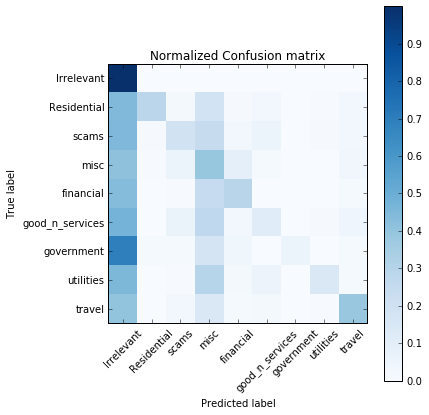

In [72]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Categoary_Index)
plt.show()

##### Passive aggresive

In [78]:
# Passive aggresive
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
start_time = time.time()
pa = PassiveAggressiveClassifier(n_iter=50)
pa.fit(X_train, target_train)
pred = pa.predict(X_test)
end_time = time.time()
print("Accuracy by Passive agresser   =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Passive agresser   =', 0.8157023183323593)
Training it took 0.3 mins


In [79]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      7552
          1       0.31      0.71      0.43       244
          2       0.20      0.67      0.31       336
          3       0.39      0.09      0.15       548
          4       0.63      0.23      0.34       397
          5       0.54      0.10      0.17       412
          6       0.25      0.24      0.25        78
          7       0.41      0.42      0.42       262
          8       0.78      0.31      0.44       437

avg / total       0.84      0.82      0.81     10266



In [80]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm
print 'relevent recall', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent precision', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))


Confussion matrix :
[[7526   10    8    1    4    1    0    1    1]
 [  13  174   42    4    4    0    2    4    1]
 [  27   36  226    7   10    5    6   15    4]
 [  44  102  245   49   17   13   18   45   15]
 [  28   57  154   25   92    5    9   20    7]
 [  37   53  194   20    6   43   10   45    4]
 [   9   14   20    7    2    3   19    3    1]
 [  13   35   80    3    5    3    7  110    6]
 [  14   82  152   10    6    7    6   25  135]]
relevent recall 0.989823874755
relevent precision 0.931834929993


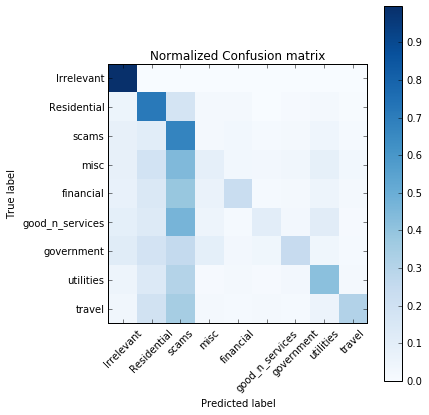

In [82]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Categoary_Index)
plt.show()

##### SVM with penality L2

In [85]:
# Support vector machine with penality L2
from sklearn.svm import LinearSVC
start_time = time.time()
sv_l = LinearSVC(loss = 'squared_hinge',penalty = 'l2', dual = False, tol = 1e-3)
sv_l.fit(X_train, target_train)
pred = sv_l.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with L2   =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with L2   =', 0.8544710695499708)
Training it took 0.2 mins


In [86]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      7552
          1       0.58      0.57      0.57       244
          2       0.40      0.35      0.37       336
          3       0.39      0.34      0.36       548
          4       0.48      0.52      0.50       397
          5       0.48      0.36      0.41       412
          6       0.36      0.22      0.27        78
          7       0.55      0.49      0.52       262
          8       0.62      0.66      0.64       437

avg / total       0.84      0.85      0.85     10266



In [88]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm
print 'relevent recall', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent precision', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))


Confussion matrix :
[[7540    2    2    1    3    2    0    1    1]
 [  19  138    8   27   16   13    2    4   17]
 [  32   11  118   44   39   42    3   13   34]
 [  50   34   57  185   96   43    9   27   47]
 [  32    8   23   68  206   15    6   19   20]
 [  45   16   46   64   20  149    5   33   34]
 [  16    6    5   15    9    5   17    0    5]
 [  18   12   11   30   21   19    4  129   18]
 [  25   11   25   38   18   20    1    9  290]]
relevent recall 0.995178786661
relevent precision 0.912675018423


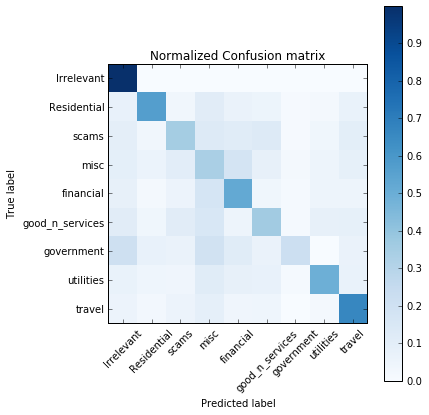

In [89]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Categoary_Index)
plt.show()

##### Random Forest

In [94]:
# random forest
start_time = time.time()
clf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
clf.fit(X_train, target_train)
pred = clf.predict(X_test)
end_time = time.time()
print("Accuracy by Random Forest =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Random Forest =', 0.8283654782778103)
Training it took 2.7 mins


In [95]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred)


Clasification report :
             precision    recall  f1-score   support

          0       0.93      1.00      0.97      7552
          1       0.80      0.35      0.49       244
          2       0.35      0.16      0.22       336
          3       0.31      0.52      0.39       548
          4       0.50      0.43      0.46       397
          5       0.41      0.14      0.21       412
          6       1.00      0.03      0.05        78
          7       0.75      0.17      0.28       262
          8       0.55      0.60      0.57       437

avg / total       0.82      0.83      0.81     10266



In [96]:
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print '\nConfussion matrix :\n', cm
print 'relevent recall', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent precision', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))


Confussion matrix :
[[7542    2    0    5    2    0    0    0    1]
 [  46   86    5   57    8   13    0    0   29]
 [  79    8   54  123   18   23    0    3   28]
 [  88    5   31  286   72   21    0    1   44]
 [  85    0    6  108  170    5    0    5   18]
 [  83    0   41  138   22   57    0    4   67]
 [  28    1    2   31    8    2    2    0    4]
 [  59    4    9   88   22    8    0   45   27]
 [  64    1    5   74   18   11    0    2  262]]
relevent recall 0.995437956204
relevent precision 0.803979366249


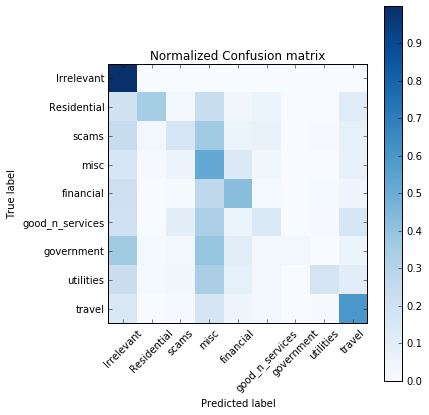

In [97]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Categoary_Index)
plt.show()

## Try to optimize LDA topic number

In [110]:
# train LDA model

topic_n = [50,100,150,200,250,300,350,400,450,500]
result_n = []
for topic_ in topic_n:
    start_time = time.time()
    lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=topic_, passes=5)
    X = lda.do_estep(corpus_tfidf, state=None)
    X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=1)
    sv_l = LinearSVC(loss = 'squared_hinge',penalty = 'l2', dual = False, tol = 1e-3)
    sv_l.fit(X_train, target_train)
    pred = sv_l.predict(X_test)
    accuracy = 1.0*sum(target_test==pred)/len(pred)
    cm = sklearn.metrics.confusion_matrix(target_test, pred)
    relevent_recall = 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
    relevent_precision = sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))
    result_n.append((sv_l,accuracy,cm,relevent_recall,relevent_precision))
    end_time = time.time()
    print "Training %i topics LDA took %.1f mins" % (topic_, (end_time-start_time)/60.0)

Training 50 topics LDA took 1.7 mins
Training 100 topics LDA took 2.3 mins
Training 150 topics LDA took 3.1 mins
Training 200 topics LDA took 4.7 mins
Training 250 topics LDA took 5.0 mins
Training 300 topics LDA took 14.9 mins
Training 350 topics LDA took 6.6 mins
Training 400 topics LDA took 8.6 mins
Training 450 topics LDA took 9.6 mins
Training 500 topics LDA took 9.8 mins


In [125]:
topic_n = [550,600,650,700]
for topic_ in topic_n:
    start_time = time.time()
    lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=topic_, passes=5)
    X = lda.do_estep(corpus_tfidf, state=None)
    X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=1)
    sv_l = LinearSVC(loss = 'squared_hinge',penalty = 'l2', dual = False, tol = 1e-3)
    sv_l.fit(X_train, target_train)
    pred = sv_l.predict(X_test)
    accuracy = 1.0*sum(target_test==pred)/len(pred)
    cm = sklearn.metrics.confusion_matrix(target_test, pred)
    relevent_recall = 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
    relevent_precision = sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))
    result_n.append((sv_l,accuracy,cm,relevent_recall,relevent_precision))
    end_time = time.time()
    print "Training %i topics LDA took %.1f mins" % (topic_, (end_time-start_time)/60.0)

Training 550 topics LDA took 15.0 mins
Training 600 topics LDA took 12.8 mins
Training 650 topics LDA took 13.1 mins
Training 700 topics LDA took 15.2 mins


In [204]:
topic_n = [800,900,1000]
for topic_ in topic_n:
    start_time = time.time()
    lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=topic_, passes=5)
    X = lda.do_estep(corpus_tfidf, state=None)
    X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=1)
    sv_l = LinearSVC(loss = 'squared_hinge',penalty = 'l2', dual = False, tol = 1e-3)
    sv_l.fit(X_train, target_train)
    pred = sv_l.predict(X_test)
    accuracy = 1.0*sum(target_test==pred)/len(pred)
    cm = sklearn.metrics.confusion_matrix(target_test, pred)
    relevent_recall = 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
    relevent_precision = sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))
    result_n.append((sv_l,accuracy,cm,relevent_recall,relevent_precision))
    end_time = time.time()
    print "Training %i topics LDA took %.1f mins" % (topic_, (end_time-start_time)/60.0)

Training 800 topics LDA took 30.3 mins
Training 900 topics LDA took 37.0 mins
Training 1000 topics LDA took 27.5 mins


In [187]:
# reset plt style
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams.update(inline_rc)
# # plt.plot(range(10))

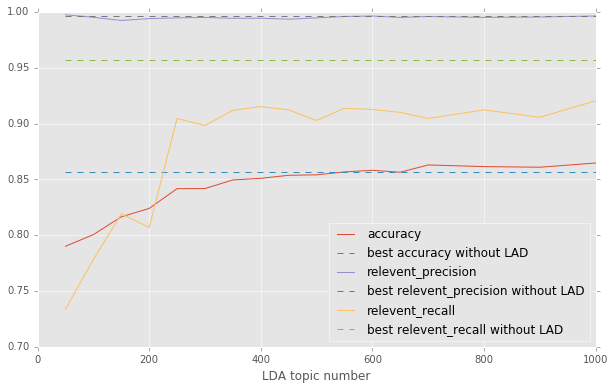

In [205]:
# plot the result and compare it with the best model we trained without LDA
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
x = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,800,900,1000]
plt.plot(x, [i[1] for i in result_n], label='accuracy')
plt.plot(x, [0.857]*len(x), '--', label='best accuracy without LAD')

plt.plot(x, [i[3] for i in result_n], label='relevent_precision')
plt.plot(x, [0.996]*len(x), '--',label='best relevent_precision without LAD')

plt.plot(x, [i[4] for i in result_n], label='relevent_recall')
plt.plot(x, [0.957]*len(x), '--',label='best relevent_recall without LAD')

xlabel('LDA topic number')

plt.legend(loc=4)

By now, we know that the result dimention deduction with LDA is no better than the result of LinearSVC without dimention deduction, and dimention deduction with LDA took longer time to train.

## Test on general tweets

In [33]:
# load tweets
twitterdata = pd.read_csv("../data/fraud_list_svarmit_location_v1.csv", header=None)
tweet_doc = list(twitterdata.iloc[:,0])
print len(twitterdata)

7401520


In [34]:
# random select 20000 tweets
selected_tweet_index = list(randint(0, len(tweet_doc),100000))
selected_tweet = [tweet_doc[i] for i in selected_tweet_index if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 20]
len(selected_tweet)

20130

In [35]:
# tokenize
tokenize_tweet = [[j.lower() for j in i.split()] for i in selected_tweet]

In [36]:
# bigram
phrases_tweet = bigram[tokenize_tweet]

In [227]:
# bag of word
corpus_tweet = [dictionary.doc2bow(text) for text in phrases_tweet]

In [231]:
# tfidf transform
corpus_tfidf_tweet = tfidf[corpus_tweet]

In [423]:
# LDA transform
X = lda.do_estep(corpus_tfidf_tweet)

Training it took 1.4 mins


In [398]:
# predict on svc model
pred_tweet = svc_multiple.predict(X)

Note: LDA model is not stable, that means when you take same input into the model, it will return different results although all results are quite similar. Below is the result I took same input and differnt results I got.

In [399]:
# test 1
pred_fraud_tweet_index = []
for a in range(9):
    pred_fraud = [i for i,j in enumerate(pred_tweet) if j==a]
    print "The amount of %s tweet: %i" % (Categoary_Index[a], len(pred_fraud))
    pred_fraud_tweet_index.append(pred_fraud)

The amount of Irrelevant tweet: 20081
The amount of Residential tweet: 1
The amount of scams tweet: 7
The amount of misc tweet: 12
The amount of financial tweet: 12
The amount of good_n_services tweet: 7
The amount of government tweet: 0
The amount of utilities tweet: 3
The amount of travel tweet: 7


In [352]:
# test 2
pred_fraud_tweet_index = []
for a in range(9):
    pred_fraud = [i for i,j in enumerate(pred_tweet) if j==a]
    print "The amount of %s tweet: %i" % (Categoary_Index[a], len(pred_fraud))
    pred_fraud_tweet_index.append(pred_fraud)

The amount of Irrelevant tweet: 20075
The amount of Residential tweet: 1
The amount of scams tweet: 7
The amount of misc tweet: 16
The amount of financial tweet: 13
The amount of good_n_services tweet: 7
The amount of government tweet: 0
The amount of utilities tweet: 3
The amount of travel tweet: 8


In [303]:
# test 3
pred_fraud_tweet_index = []
for a in range(9):
    pred_fraud = [i for i,j in enumerate(pred_tweet) if j==a]
    print "The amount of %s tweet: %i" % (Categoary_Index[a], len(pred_fraud))
    pred_fraud_tweet_index.append(pred_fraud)

The amount of Irrelevant tweet: 20077
The amount of Residential tweet: 1
The amount of scams tweet: 8
The amount of misc tweet: 15
The amount of financial tweet: 12
The amount of good_n_services tweet: 7
The amount of government tweet: 0
The amount of utilities tweet: 3
The amount of travel tweet: 7


In [306]:
# print the result (the tweets that model selected as fraud relevent)
for i,j in enumerate(pred_fraud_tweet_index):
    if i != 0:
        print "Recognized as %s tweet:" % (Categoary_Index[i])
        print "\n"
        for k in j:
            print selected_tweet[k]
            print "------"
    print "\n"
    print "___________________________________________________________________________________________________________"



___________________________________________________________________________________________________________
Recognized as Residential tweet:


The other day a friend said  "Mika I'm a weak person cuz I struggle with depression..I answered telling me that took strength not weakness!
------


___________________________________________________________________________________________________________
Recognized as scams tweet:


Ok ok hold the phone!!  I never went through any bf phone until my ex and he was hella shady. And it was years after we started dating
------
@travisk All I asked for was to pay me right and get out of my way #Uber. Last I asked for was dont send a driver for a pick up that's...
------
RT @RodBelgrave: Could somebody contact Yasmin's carer,she's broken free of the restraints and has gained access to the computer room https
------
Customer service phone support that doesn't include an automatic call back option instead of sitting on hold in 2016 is pretty criminal

## customize test demo

In [408]:
def lda_transform(test):
    token = [[i.lower() for i in j.split()] for j in test]
    phrases = bigram[token]
    corpus = [dictionary.doc2bow(i) for i in phrases]
    corpus_tfidf = tfidf[corpus]
    X_test = lda.do_estep(corpus_tfidf, state=None)
    return X_test

In [356]:
# result of test 1 above
print pred_fraud_tweet_index[1:]

[[6684], [2854, 3580, 11399, 11495, 13438, 14328, 19884], [2142, 3638, 3640, 7351, 8036, 8177, 10326, 10732, 11115, 11255, 12433, 14478, 14574, 14972, 16574, 19666], [1697, 2870, 5218, 8354, 9466, 11453, 11979, 13469, 14151, 14249, 16036, 16533, 20077], [1496, 5264, 5997, 6495, 6816, 13259, 19028], [], [15321, 17138, 18575], [161, 525, 6653, 9921, 11514, 12000, 18649, 19584]]


In [400]:
# result of test 2 above
print pred_fraud_tweet_index[1:]

[[6684], [2854, 3580, 11399, 11495, 13438, 14328, 19884], [2142, 3638, 3640, 7351, 8036, 10732, 11115, 12433, 14478, 14574, 14972, 19666], [1697, 2870, 5218, 8354, 9466, 11453, 11979, 13469, 14151, 16036, 16533, 20077], [1496, 5264, 5997, 6495, 6816, 13259, 19028], [], [15321, 17138, 18575], [161, 525, 9921, 11514, 12000, 18649, 19584]]


In [421]:
# try the tweet that selected two times by the model 
selected_tweet[2854]

"@travisk All I asked for was to pay me right and get out of my way #Uber. Last I asked for was dont send a driver for a pick up that's..."

In [420]:
for i in range(10):
    test_demo = [selected_tweet[2854]]
    test_result = svc_multiple.predict(lda_transform(test_demo))
    print "The test tweet is recognized as %s tweet" % Categoary_Index[test_result[0]]

The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet
The test tweet is recognized as scams tweet


In [209]:
# try the tweet that selected one time by the model in two time selection, from this case we see how unstable the model is
# selected_tweet[8177]

In [422]:
for i in range(10):
    test_demo = [selected_tweet[8177]]
    test_result = svc_multiple.predict(lda_transform(test_demo))
    print "The test tweet is recognized as %s tweet" % Categoary_Index[test_result[0]]

The test tweet is recognized as misc tweet
The test tweet is recognized as Irrelevant tweet
The test tweet is recognized as Irrelevant tweet
The test tweet is recognized as Irrelevant tweet
The test tweet is recognized as misc tweet
The test tweet is recognized as Irrelevant tweet
The test tweet is recognized as misc tweet
The test tweet is recognized as misc tweet
The test tweet is recognized as Irrelevant tweet
The test tweet is recognized as Irrelevant tweet


## Get some relevent tweets

In [487]:
# caculate choosing rate of the model
rate = (20130-20080)/20130.0
rate

0.0024838549428713363

In [490]:
# estimate how many fraud relevent tweets we can get from 500,000 by the model
input_number = 500000
tim = (input_number/20000)*1.6
amount = input_number*rate
print tim
print amount

40.0
1241.92747144


In [445]:
# random select 500,000 tweets
selected_tweet_index = list(randint(0, len(tweet_doc),2500000))
selected_tweet = [tweet_doc[i] for i in selected_tweet_index if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 20]
len(selected_tweet)

501315

In [450]:
# train the modle and print the result
start_time = time.time()
test_result = svc_multiple.predict(lda_transform(selected_tweet))
pred_fraud_tweet_index = []
for a in range(9):
    pred_fraud = [i for i,j in enumerate(test_result) if j==a]
    print "The amount of %s tweet: %i" % (Categoary_Index[a], len(pred_fraud))
    pred_fraud_tweet_index.append(pred_fraud)
selected_relevent_tweet = [[selected_tweet[j] for j in i] for i in pred_fraud_tweet_index [1:]]
end_time = time.time()
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

The amount of Irrelevant tweet: 500075
The amount of Residential tweet: 31
The amount of scams tweet: 131
The amount of misc tweet: 529
The amount of financial tweet: 298
The amount of good_n_services tweet: 83
The amount of government tweet: 4
The amount of utilities tweet: 60
The amount of travel tweet: 104
Training it took 38.0 mins


In [451]:
# how many tweets recognized as fraud relevent by the model
501315-500075

1240

In [452]:
selected_relevent_tweet[0][:10]

['Pretty sure they give out dum-dums out at the bank because they know how stupid u are to trust them with your money. #Bankrupt',
 'I have a MCU that has 22 pins, despite data sheet and supplier site saying 20 pins. Need to go lie down.',
 '@chlobowzz Sounds like you have an amazing year ahead! Let us know if you need a place to call home while in NYC :)',
 'RT @redallover99: "journalism is not a crime"\nexcept it is often criminal\nour msm &amp; so called independent media prove this on a daily basis',
 'RT @MiriamRoseMc: Pay bonuses should be reserved for private employment\n\nGovt employees ie: TSA, IRS should never receive bonuses,  paid we',
 'RT @DCWasteBook: #DCWaste: In 2013, #USGov paid\n$124M to USIS, contractor hired to do background checks, despite security failures &amp; fraud',
 'I think there is something wrong when i am actually crying because I have to go to work tonight I hate that place and the people ',
 'RT @smittie61984: If people kept their full pay checks and p

In [455]:
# export the data
pickle.dump(selected_relevent_tweet, open('selected_relevent_tweet.pkl', 'wb')) 
# obj = cPickle.load(open('selected_relevent_tweet.pkl', 'rb'))